In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from xml.dom.minidom import Attr
import numpy as np
import pandas as pd
import datetime
import torch

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 


class BaseLoader:
    """
    Class to laod KEATS dataset as OHV input, although actualy output is essentially indexes of the onehot vector position
    as data will be used in a GritNet model that uses Embedding layer.

    Takes in columns type and output type from cfg
    Columns type to specify which fields to use. Output type Binary or multivariative (support not added yet) 

    """    

    def __init__(self, cfg, checkpoint_folder=None):

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.load_method = cfg.LOAD_METHOD
        try:
            self.class_sizes = cfg.CLASS_SPLIT
        except AttributeError:
            self.class_sizes = None
        
        
        self.checkpoint_folder = checkpoint_folder


    def create_dataset(self):
        pass
    
    def split_class_sets(self, all_class_sets, test_split_ratio=0.2):
        train_sets = []
        test_sets = []
        for class_sets in all_class_sets:
            split = train_test_split(*class_sets, test_size=test_split_ratio, random_state=0)
            train_split = []
            test_split = []
            for i in range(0, len(split), 2):
                train_split.append(split[i])
                test_split.append(split[i+1])
            train_sets.append(train_split)
            test_sets.append(test_split)
        return train_sets, test_sets
            
    def oversample(self, all_class_sets, max_sample_per_class):
        for i in range(len(all_class_sets)):
            num_to_duplicate = max_sample_per_class - all_class_sets[i][0].shape[0]
            if num_to_duplicate > 0:
                indexes_to_duplicate = np.random.choice(np.arange(all_class_sets[i][0].shape[0]), size=num_to_duplicate)
                for j in range(len(all_class_sets[i])):
                    all_class_sets[i][j] = torch.cat([all_class_sets[i][j], all_class_sets[i][j][indexes_to_duplicate]])
        return all_class_sets
    
    def combine_classes(self, all_class_sets, controlled=False):
        dataset = [[] for i in range(len(all_class_sets[0]))]
        
        for i, class_set in enumerate(all_class_sets):
            if controlled and self.class_sizes is not None:
                class_size = self.class_sizes[i] 
                indexes = np.random.choice(np.arange(class_set[0].shape[0]), size=class_size)
            else:
                indexes = np.arange(class_set[0].shape[0])

            for j, each in enumerate(class_set):
                dataset[j].append(each[indexes])
        
        for i in range(len(dataset)):
            dataset[i] = torch.cat(dataset[i])

        return dataset

    def load_dataset(self, test_split_ratio=0.2):
        datasets = self.create_dataset() ## [x, y]
        classes = list(datasets[-1].unique())
        
        ## for each class seprate [x,y] in all_class_sets
        all_class_sets = [] 
        max_sample_per_class = 0
        for each_class in classes:
            class_sets = []
            for each_dataset in datasets:
                class_samples = each_dataset[datasets[-1] == each_class]
                class_sets.append(class_samples)
            all_class_sets.append(class_sets)
            
            if class_sets[0].shape[0] > max_sample_per_class:
                max_sample_per_class = class_sets[0].shape[0]

        train_sets, test_sets = self.split_class_sets(all_class_sets, test_split_ratio)
        
        if self.load_method == "OVERSAMPLE_NON_MAX_TRAIN":
            max_sample_per_class = int(max_sample_per_class * (1-test_split_ratio))
            train_sets = self.oversample(train_sets[:], max_sample_per_class)

        dataset_train = shuffle(*self.combine_classes(train_sets, True), random_state=0)
        dataset_test = shuffle(*self.combine_classes(test_sets), random_state=0)

        print("Train:", dataset_train[0].shape[0])
        print("Test:", dataset_test[0].shape[0])
        print("Max sample per class:", max_sample_per_class)

        return dataset_train, dataset_test


In [3]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import transforms 

class MNISTLoader(BaseLoader):

    def __init__(self, cfg, checkpoint_folder=None):
        super(MNISTLoader, self).__init__(cfg)

        self.train_data = datasets.MNIST(root='raw_data_sets/', train=True, transform=transforms.ToTensor(), download=True)
        self.test_data = datasets.MNIST(root='raw_data_sets/', train=False, transform=transforms.ToTensor(), download=True)


    def create_dataset(self):
        
        x_train, y_train = self.train_data.data, self.train_data.targets
        x_test, y_test = self.test_data.data, self.test_data.targets

        x_train = x_train.view(x_train.shape[0], -1).type(torch.FloatTensor)
        x_test = x_test.view(x_test.shape[0], -1).type(torch.FloatTensor)

        return torch.cat([x_train, x_test]).to(self.device), torch.cat([y_train, y_test]).type(torch.LongTensor).to(self.device)
    
    def load_dataset(self, test_split_ratio=0.2):
        train, test = super().load_dataset(test_split_ratio)
        return train[0], train[1], test[0], test[1]

In [4]:

import datetime
from tabnanny import check

import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path

import matplotlib.pyplot as plt
import shutil

class BaseModel:

    def __init__(self, cfg, checkpoint_folder, dataprocessor):

        self.checkpoint_folder = checkpoint_folder

        self.batch_size = cfg.BATCH_SIZE
        
        try:
            self.drop_prob = cfg.DROP_PROB
        except AttributeError:
            self.drop_prob = None

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.lr = cfg.LR
        self.total_epoch = cfg.EPOCH
        self.loss_fn_name = cfg.LOSS
        self.optim_name = cfg.OPTIMIZER
        self.PRINT_EVERY = cfg.PRINT_EVERY
        self.dataprocessor = dataprocessor
        
    def set_model(self, **kwargs):
        raise Exception("Not Implemented")

    def update_per_iter(self):
        pass
    
    def update_per_epoch(self):
        pass

    def train(self, train_loader):
        
        self.loss_fn = getattr(nn, self.loss_fn_name)()
        self.optimizer = getattr(optim, self.optim_name)(self.model.parameters(), lr=self.lr)

        ep = 1
        print_track_step = 0
        self.model.train()
        all_losses = []
        epoch_losses = []

        for epoch in range(self.total_epoch):
            batch_losses = []
            for batch_idx, example, in enumerate(train_loader):
                
                result = example[-1]
                scores = self.model(example[:-1]).squeeze(1)
                loss = self.loss_fn(scores, result)
                all_losses.append(loss.item())
                batch_losses.append(loss.item())
                self.optimizer.zero_grad()
                loss.backward()

                self.update_per_iter()
                
                self.optimizer.step()
                print_track_step += 1
                if print_track_step % self.PRINT_EVERY == 0:
                    print(f'epoch: {epoch + 1} step: {batch_idx + 1}/{len(train_loader)} loss: {loss}')
                    print_track_step = 0

            print(f'epoch: {epoch + 1} loss: {sum(batch_losses)/len(batch_losses)}')
            print_track_step = 0
            checkpoint_name = self.checkpoint_folder / Path("checkpoint_e"+str(epoch)+".pt")
            torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        }, checkpoint_name)
            ep += 1
            epoch_losses.append(sum(batch_losses)/len(batch_losses))
            
            self.update_per_epoch()

        checkpoint_name = self.checkpoint_folder / Path("model.pt")
        torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'all_losses': all_losses,
                    'epoch_losses': epoch_losses,
                    }, checkpoint_name)

        plt.figure(0)          
        plt.plot([i for i in range(len(all_losses))], all_losses)
        plt.savefig(self.checkpoint_folder / Path("all_losses.png"))
        
        plt.figure(1)
        plt.plot([i for i in range(len(epoch_losses))], epoch_losses)
        plt.savefig(self.checkpoint_folder / Path("epoch_losses.png"))
        


    def predict(self, X, threshold=0.5):
        pass

    def fit(self, X, y_train):
        pass

In [5]:
import torch
import torch.nn as nn


class GradBasedDropout(nn.Module):
    def __init__(self, input_dim, drop_prob):
        super(GradBasedDropout, self).__init__()
        self.keep_prob = torch.ones(input_dim).to(device)
        self.drop_prob = drop_prob
    
    def update_keep_prob(self, grad, method):
        if method == "TANH":
            self.keep_prob = torch.tanh(torch.abs(grad).sum(dim=-1))
            if self.drop_prob is not None:
                # scale to 1-DROP_PROB to 1 if specified, else left as 0 to 1  range
                self.keep_prob = (self.keep_prob * self.drop_prob) + (1-self.drop_prob)
        elif method == "ABS_NORM":
            grad = torch.abs(grad).sum(dim=-1)
            self.keep_prob = (grad - torch.min(grad))/(torch.max(grad) - torch.min(grad) + 1e-7)
            if self.drop_prob is not None:
                # scale to 1-DROP_PROB to 1 if specified, else left as 0 to 1  range
                self.keep_prob = (self.keep_prob * self.drop_prob) + (1-self.drop_prob)
        elif method == "NORM":
            grad = grad.sum(dim=-1)
            self.keep_prob = (grad - torch.min(grad))/(torch.max(grad) - torch.min(grad) + 1e-7)
            if self.drop_prob is not None:
                # scale to 1-DROP_PROB to 1 if specified, else left as 0 to 1  range
                self.keep_prob = (self.keep_prob * self.drop_prob) + (1-self.drop_prob)
        
        ## The idea is to keep neurons with higher gradients stay
        ## and drop neurons with low gradients
        # print(self.drop_prob)
        # print(grad.max(), grad.min(), grad.mean())
        # print(self.keep_prob.max(), self.keep_prob.min(), self.keep_prob.mean())
        ## doing the opposite could be:
        # self.keep_prob = 1-self.keep_prob

    def forward(self, x):
        keep_prob = torch.ones(x.shape).to(device) * torch.unsqueeze(self.keep_prob, dim=0) # for all batches same probability
        keep_prob = torch.clip(keep_prob, min=0.00001, max=1)
        mask = torch.bernoulli(keep_prob) * 1/keep_prob
        return mask * x

class LinearWithGradBasedDropout(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout_prob):
        super(LinearWithGradBasedDropout, self).__init__()

        self.fc = nn.Linear(input_dim, hidden_dim)
        self.drop = GradBasedDropout(hidden_dim, dropout_prob)
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.drop(self.activation(self.fc(x)))

class LinearWithNoDropout(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super(LinearWithNoDropout, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        return self.activation(self.fc(x))

class LinearModel(nn.Module):

    def __init__(self, linear_layer, hidden_dim=2048, target_size=1):

        super(LinearModel, self).__init__()
        
        self.target_size = target_size
        
        self.linear_layer = linear_layer
        self.dense = nn.Linear(hidden_dim, target_size)
        if target_size > 1:
            self.out = nn.LogSoftmax(dim=-1)
        else:
            self.out = nn.Sigmoid()
        
    def forward(self, x):
        x = x[0]
        x = self.linear_layer(x)
        return self.out(self.dense(x))

In [6]:

class LinearModelNoDropout(BaseModel):

    def __init__(self, cfg, train_path, input_dim, dataprocessor, hidden_dim=2048):
        super(LinearModelNoDropout, self).__init__(cfg, train_path, dataprocessor)
        
        target_size = 1
        if cfg.OUTPUT_TYPE == "GRADE":
            target_size = 5
        elif cfg.OUTPUT_TYPE == "NUMBERS":
            target_size = 10
        self.set_model(input_dim, hidden_dim, target_size)

    def set_model(self, input_dim, hidden_dim, target_size):
        layer = LinearWithNoDropout(input_dim, hidden_dim).to(self.device)
        self.model = LinearModel(layer, hidden_dim, target_size).to(self.device)

    def predict(self, X, threshold=0.5):
        y_preds = []

        with torch.no_grad():
            self.model.eval()    
            for i in range(0,X.shape[0], self.batch_size):
                y_preds.append(self.model((X[i:min(X.shape[0], i+self.batch_size)],)))

        if y_preds[0].shape[-1] > 1:
            yp = torch.argmax(torch.cat(y_preds, dim=0), dim=1).cpu()
            return yp

        return torch.squeeze(torch.cat(y_preds,dim=0).cpu() > threshold, 1)

    def fit(self, X, y_train):
        train_dataset = torch.utils.data.TensorDataset(X, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size)

        self.train(train_loader)


In [7]:

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import geometric_mean_score as gmean_score

def confusion_matrix_dict(y_predicted, y_target):
    cm = confusion_matrix(y_target, y_predicted)
    return f"Confusion matrix = {cm}\n"
    

def get_f1_score(y_predicted, y_target):
    return f"F1 Score = {f1_score(y_target, y_predicted, average='macro')}\n"
    
def get_precision(y_predicted, y_target):
    return f"Precision = {precision_score(y_target, y_predicted, average='macro')}\n"

def get_recall(y_predicted, y_target): ### TODO: UAR consideration
    return f"Recall = {recall_score(y_target, y_predicted, average='macro')}\n"

def get_roc_auc(y_predicted, y_target):
    return f"ROC AUC = {roc_auc_score(y_target, y_predicted)}\n"

def get_gmean(y_predicted, y_target):
    return f"Geometric Mean = {gmean_score(y_target, y_predicted)}\n"

def get_accuracy(y_predicted, y_target):
    return f"Accuracy = {accuracy_score(y_target, y_predicted)}\n"

def get_evaluation_methods(cfg):
    evaluation_methods = cfg.EVALUATION_METHODS
    methods = []
    for each in evaluation_methods:
        if each == "CONFUSION_MATRIX":
            methods.append(confusion_matrix_dict)
        elif each == "ACCURACY":
            methods.append(get_accuracy)
        elif each == "F1_SCORE":
            methods.append(get_f1_score)
        elif each == "PRECISION":
            methods.append(get_precision)
        elif each == "RECALL" or each == "UAR":
            methods.append(get_recall)
        elif each == "GMEAN":
            methods.append(get_gmean)
        else:
            raise Exception(f"Requested evaluation method {each} is not supported")
    return methods 

def evaluate(cfg, model, X_train, X_test, y_train, y_test):
    evaluation_methods = get_evaluation_methods(cfg)
    evaluation_result = "Train\n"
    for each_method in evaluation_methods:
        y_preds = model.predict(X_train)
        evaluation_result += each_method(y_preds, y_train.cpu())
    evaluation_result += "\n\nTest\n"
    for each_method in evaluation_methods:
        y_preds = model.predict(X_test)
        evaluation_result += each_method(y_preds, y_test.cpu())
    print(evaluation_result)


In [8]:
# Seed 
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)


## No Dropout

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting raw_data_sets/MNIST/raw/train-images-idx3-ubyte.gz to raw_data_sets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting raw_data_sets/MNIST/raw/train-labels-idx1-ubyte.gz to raw_data_sets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting raw_data_sets/MNIST/raw/t10k-images-idx3-ubyte.gz to raw_data_sets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting raw_data_sets/MNIST/raw/t10k-labels-idx1-ubyte.gz to raw_data_sets/MNIST/raw

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.21377596259117126
epoch: 1 loss: 1.0409356705309485
epoch: 2 step: 1000/1750 loss: 0.04026510566473007
epoch: 2 loss: 0.07816559606786125
epoch: 3 step: 1000/1750 loss: 0.024359095841646194
epoch: 3 loss: 0.020853066894750166
epoch: 4 step: 1000/1750 loss: 0.005158317741006613
epoch: 4 loss: 0.006633819548754478
epoch: 5 step: 1000/1750 loss: 0.002913146745413542
epoch: 5 loss: 0.0023396239768959017
epoch: 6 step: 1000/1750 loss: 0.0016682872083038092
epoch: 6 loss: 0.0012439973281074604
epoch: 7 step: 1000/1750 loss: 0.0012412462383508682
epoch: 7 loss: 0.0009076651710794132
epoch: 8 step: 1000/1750 loss: 0.0009792238706722856
epoch: 8 loss: 0.0007428881849855316
epoch: 9 step: 1000/1750 loss: 0.0008359475759789348
epoch: 9 loss: 0.000638785821990317
epoch: 10 step: 1000/1750 loss: 0.0007269852794706821
epoch: 10 

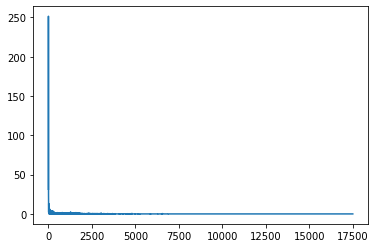

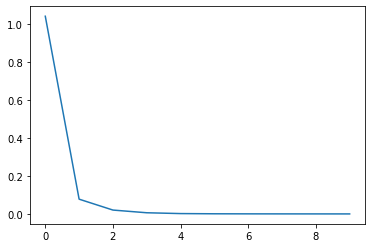

In [9]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'NORM',
    'DROP_PROB': 0.2,
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelNoDropout(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

In [38]:
s = torch.tensor([-1,3,4,5])
g = torch.tensor([-3,0,2,-10])
m = torch.max(torch.abs(s), torch.abs(g))
print(m)
print(torch.sign(s))
print(m == torch.abs(s))
print( ((m == torch.abs(s)) * torch.sign(s)).int())
m = m * (((m == torch.abs(s)) * torch.sign(s)) |  ((m == torch.abs(g)) * torch.sign(g)))
print(m)

tensor([ 3,  3,  4, 10])
tensor([-1,  1,  1,  1])
tensor([False,  True,  True, False])
tensor([0, 1, 1, 0], dtype=torch.int32)
tensor([ -3,   3,   4, -10])


In [42]:
class LinearModelGradBasedDrop(LinearModelNoDropout):
    
    def __init__(self, cfg, train_path, input_dim, dataprocessor, **kwargs):
        super(LinearModelGradBasedDrop, self).__init__(cfg, train_path, input_dim, dataprocessor, **kwargs)
        self.prob_method = cfg.PROB_METHOD
    
    def set_model(self, input_dim, hidden_dim, target_size):
        layer = LinearWithGradBasedDropout(input_dim, hidden_dim, self.drop_prob)
        self.model = LinearModel(layer, hidden_dim, target_size).to(self.device)

    def update_per_iter(self):
        self.model.linear_layer.drop.update_keep_prob(self.model.linear_layer.fc.weight.grad.detach(), self.prob_method)

class LinearModelGradBasedDropV2(LinearModelNoDropout):
    
    def __init__(self, cfg, train_path, input_dim, dataprocessor, **kwargs):
        super(LinearModelGradBasedDropV2, self).__init__(cfg, train_path, input_dim, dataprocessor, **kwargs)
        self.prob_method = cfg.PROB_METHOD

        self.input_dim = input_dim
        self.grads = torch.zeros(2048, input_dim).to(device)
    
    def set_model(self, input_dim, hidden_dim, target_size):
        layer = LinearWithGradBasedDropout(input_dim, hidden_dim, self.drop_prob)
        self.model = LinearModel(layer, hidden_dim, target_size).to(self.device)

    def update_per_iter(self):
        self.grads += self.model.linear_layer.fc.weight.grad.detach()

    def update_per_epoch(self):
        self.model.linear_layer.drop.update_keep_prob(self.grads, self.prob_method)
        self.grads = torch.zeros(2048, self.input_dim).to(device)

class LinearModelGradBasedDropV3(LinearModelNoDropout):
    
    def __init__(self, cfg, train_path, input_dim, dataprocessor, **kwargs):
        super(LinearModelGradBasedDropV3, self).__init__(cfg, train_path, input_dim, dataprocessor, **kwargs)
        self.prob_method = cfg.PROB_METHOD
        self.grads = None
    
    def set_model(self, input_dim, hidden_dim, target_size):
        layer = LinearWithGradBasedDropout(input_dim, hidden_dim, self.drop_prob)
        self.model = LinearModel(layer, hidden_dim, target_size).to(self.device)

    def update_per_iter(self):
        if self.grads is None:
            self.grads = self.model.linear_layer.fc.weight.grad.detach()
        else:
            cur_grads = self.model.linear_layer.fc.weight.grad.detach()
            new_grads = torch.max(torch.abs(self.grads), torch.abs(cur_grads))
            new_grads = new_grads * (((new_grads == torch.abs(self.grads)) * torch.sign(self.grads)).int() | ((new_grads == torch.abs(cur_grads)) * torch.sign(cur_grads)).int())
            
            self.grads = new_grads


    def update_per_epoch(self):
        self.model.linear_layer.drop.update_keep_prob(self.grads, self.prob_method)
        self.grards = None
        

## V1

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.029033316299319267
epoch: 1 loss: 1.0855013719147704
epoch: 2 step: 1000/1750 loss: 0.08953585475683212
epoch: 2 loss: 0.1020672316788966
epoch: 3 step: 1000/1750 loss: 0.005456344690173864
epoch: 3 loss: 0.04474946562800584
epoch: 4 step: 1000/1750 loss: 0.005136524792760611
epoch: 4 loss: 0.023569930555622703
epoch: 5 step: 1000/1750 loss: 0.0009279388468712568
epoch: 5 loss: 0.0154925262085548
epoch: 6 step: 1000/1750 loss: 0.004184164106845856
epoch: 6 loss: 0.012061298541870038
epoch: 7 step: 1000/1750 loss: 0.0023110846523195505
epoch: 7 loss: 0.008500669893756627
epoch: 8 step: 1000/1750 loss: 0.08144950866699219
epoch: 8 loss: 0.005838018651087883
epoch: 9 step: 1000/1750 loss: 0.0007616200018674135
epoch: 9 loss: 0.005071560133615744
epoch: 10 step: 1000/1750 loss: 0.005858011543750763
epoch: 10 loss: 0.004006456820527595
Train
Accuracy = 0.9991785127509107
F1 Score = 0.9991516464064327
Precis

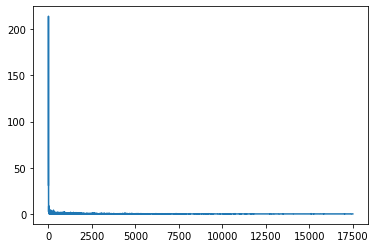

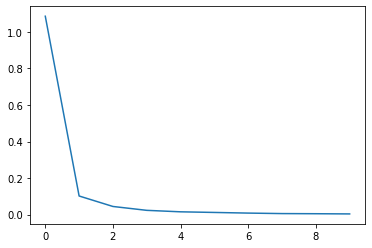

In [11]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'NORM',
    'DROP_PROB': 0.2,
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDrop(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.41027235984802246
epoch: 1 loss: 3.065504175732777
epoch: 2 step: 1000/1750 loss: 0.4441238343715668
epoch: 2 loss: 0.4159587083489501
epoch: 3 step: 1000/1750 loss: 0.07013493776321411
epoch: 3 loss: 0.34073345561754625
epoch: 4 step: 1000/1750 loss: 0.19535110890865326
epoch: 4 loss: 0.2581309843178481
epoch: 5 step: 1000/1750 loss: 0.10210801661014557
epoch: 5 loss: 0.27109156486880964
epoch: 6 step: 1000/1750 loss: 2.3027191162109375
epoch: 6 loss: 9.486998376033386
epoch: 7 step: 1000/1750 loss: 2.3024210929870605
epoch: 7 loss: 14.761707360812595
epoch: 8 step: 1000/1750 loss: 2.3022642135620117
epoch: 8 loss: 9.597864674976893
epoch: 9 step: 1000/1750 loss: 2.3021788597106934
epoch: 9 loss: 11.995353436435806
epoch: 10 step: 1000/1750 loss: 0.11233313381671906
epoch: 10 loss: 0.20174202854101272
Train
Accuracy = 0.9602650189299236
F1 Score = 0.9607234495971826
Precision = 0.9598865179885282
Reca

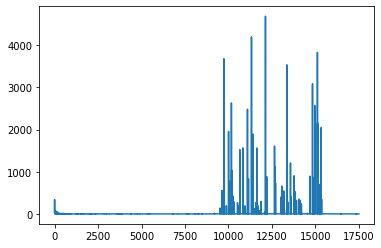

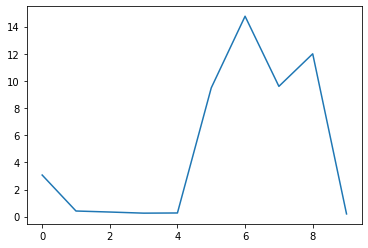

In [12]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'NORM',
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDrop(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.1008516475558281
epoch: 1 loss: 1.1585729277069914
epoch: 2 step: 1000/1750 loss: 0.045484963804483414
epoch: 2 loss: 0.12633628313102652
epoch: 3 step: 1000/1750 loss: 0.02784821391105652
epoch: 3 loss: 0.06924497038228453
epoch: 4 step: 1000/1750 loss: 0.05908462777733803
epoch: 4 loss: 0.04680376447651153
epoch: 5 step: 1000/1750 loss: 0.050923850387334824
epoch: 5 loss: 0.03245354009355443
epoch: 6 step: 1000/1750 loss: 0.2704203724861145
epoch: 6 loss: 0.026180027517610532
epoch: 7 step: 1000/1750 loss: 0.004689046647399664
epoch: 7 loss: 0.019621385391713504
epoch: 8 step: 1000/1750 loss: 0.02805110439658165
epoch: 8 loss: 0.014442923658572129
epoch: 9 step: 1000/1750 loss: 0.05566292628645897
epoch: 9 loss: 0.014364261603992937
epoch: 10 step: 1000/1750 loss: 0.15213705599308014
epoch: 10 loss: 0.012923492042477652
Train
Accuracy = 0.9962140152868062
F1 Score = 0.9963238887137977
Precision = 0.9

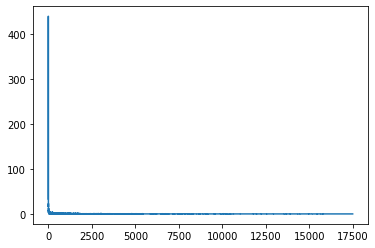

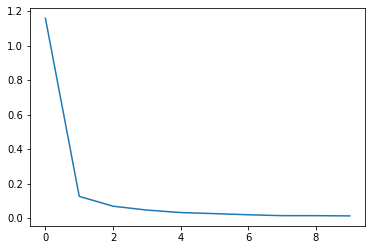

In [13]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'ABS_NORM',
    'DROP_PROB': 0.2,
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDrop(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 2.3041646480560303
epoch: 1 loss: 782.3639841158731
epoch: 2 step: 1000/1750 loss: 2056.769287109375
epoch: 2 loss: 420.672047306742
epoch: 3 step: 1000/1750 loss: 2.303265333175659
epoch: 3 loss: 1104.3978104318892
epoch: 4 step: 1000/1750 loss: 2.30303955078125
epoch: 4 loss: 617.5113979475839
epoch: 5 step: 1000/1750 loss: 2.3028564453125
epoch: 5 loss: 236.193984920093
epoch: 6 step: 1000/1750 loss: 2080.592041015625
epoch: 6 loss: 148.89333449568068
epoch: 7 step: 1000/1750 loss: 2.3026669025421143
epoch: 7 loss: 119.25075001307896
epoch: 8 step: 1000/1750 loss: 2.3026046752929688
epoch: 8 loss: 76.48359180777413
epoch: 9 step: 1000/1750 loss: 2.302565097808838
epoch: 9 loss: 126.3397740688324
epoch: 10 step: 1000/1750 loss: 2.3025636672973633
epoch: 10 loss: 91.11334977299826


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train
Accuracy = 0.11249017786984784
F1 Score = 0.020426683861199085
Precision = 0.023754691689008043
Recall = 0.09990722154108919
Geometric Mean = 0.0


Test
Accuracy = 0.112539274493002
F1 Score = 0.0203611238325501
Precision = 0.04458815682911724
Recall = 0.09995616481657091
Geometric Mean = 0.0



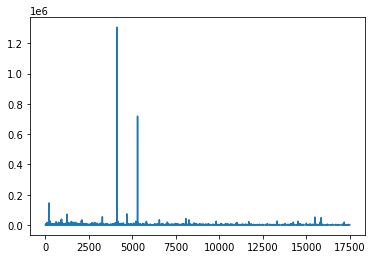

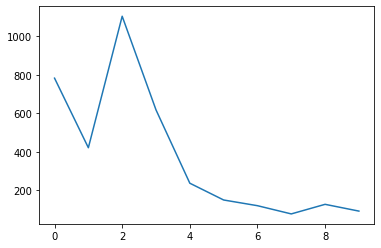

In [14]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'ABS_NORM',
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDrop(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.3505474030971527
epoch: 1 loss: 141.55818234181405
epoch: 2 step: 1000/1750 loss: 0.1204739362001419
epoch: 2 loss: 112.8306308616634
epoch: 3 step: 1000/1750 loss: 0.40019017457962036
epoch: 3 loss: 72.52798726591254
epoch: 4 step: 1000/1750 loss: 0.20995809137821198
epoch: 4 loss: 73.5212428313185
epoch: 5 step: 1000/1750 loss: 0.2661950886249542
epoch: 5 loss: 84.43492656440287
epoch: 6 step: 1000/1750 loss: 0.2358325719833374
epoch: 6 loss: 91.00968577166967
epoch: 7 step: 1000/1750 loss: 633.4234008789062
epoch: 7 loss: 82.54362252505763
epoch: 8 step: 1000/1750 loss: 0.3640236258506775
epoch: 8 loss: 57.43438885491022
epoch: 9 step: 1000/1750 loss: 0.34971553087234497
epoch: 9 loss: 43.85544775757406
epoch: 10 step: 1000/1750 loss: 0.33064040541648865
epoch: 10 loss: 50.6645359177781
Train
Accuracy = 0.8895635402528752
F1 Score = 0.8871236596432072
Precision = 0.8907584104567915
Recall = 0.886850

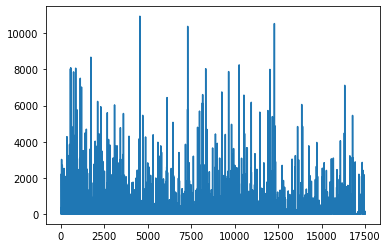

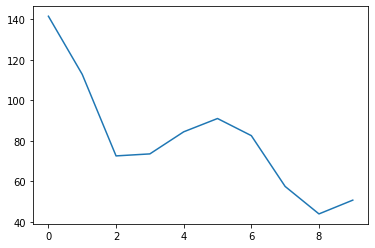

In [15]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'TANH',
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDrop(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.25163787603378296
epoch: 1 loss: 1.2011081443996852
epoch: 2 step: 1000/1750 loss: 0.05300094559788704
epoch: 2 loss: 0.11973173815590729
epoch: 3 step: 1000/1750 loss: 0.05175848305225372
epoch: 3 loss: 0.06897988861735628
epoch: 4 step: 1000/1750 loss: 0.011781205423176289
epoch: 4 loss: 0.04143958110635244
epoch: 5 step: 1000/1750 loss: 0.03266526758670807
epoch: 5 loss: 0.03133433565381451
epoch: 6 step: 1000/1750 loss: 0.01818706840276718
epoch: 6 loss: 0.023884425484644974
epoch: 7 step: 1000/1750 loss: 0.012548310682177544
epoch: 7 loss: 0.020554669024048896
epoch: 8 step: 1000/1750 loss: 0.09104917198419571
epoch: 8 loss: 0.017317577424335987
epoch: 9 step: 1000/1750 loss: 0.007153002079576254
epoch: 9 loss: 0.015003300008305034
epoch: 10 step: 1000/1750 loss: 0.00949674379080534
epoch: 10 loss: 0.01273168586152542
Train
Accuracy = 0.9969640688620616
F1 Score = 0.9968177202673161
Precision = 0.

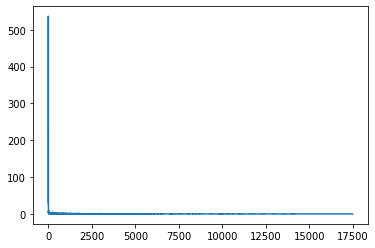

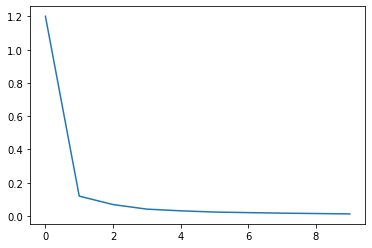

In [16]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'TANH',
    'DROP_PROB': 0.2,
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDrop(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

## V2

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.5440689325332642
epoch: 1 loss: 1.0080662886390037
epoch: 2 step: 1000/1750 loss: 0.052991751581430435
epoch: 2 loss: 0.11297115542321262
epoch: 3 step: 1000/1750 loss: 0.019251063466072083
epoch: 3 loss: 0.05105151807855353
epoch: 4 step: 1000/1750 loss: 0.005391187034547329
epoch: 4 loss: 0.026035468838601188
epoch: 5 step: 1000/1750 loss: 0.05600795894861221
epoch: 5 loss: 0.01862215878006048
epoch: 6 step: 1000/1750 loss: 0.008630427531898022
epoch: 6 loss: 0.013355604248898414
epoch: 7 step: 1000/1750 loss: 0.009108386002480984
epoch: 7 loss: 0.009061531950936374
epoch: 8 step: 1000/1750 loss: 0.00132947217207402
epoch: 8 loss: 0.0067093904888887845
epoch: 9 step: 1000/1750 loss: 0.0035808756947517395
epoch: 9 loss: 0.006553847246513214
epoch: 10 step: 1000/1750 loss: 0.001279422314837575
epoch: 10 loss: 0.005022120391238417
Train
Accuracy = 0.9983570255018216
F1 Score = 0.9985584028428637
Precisi

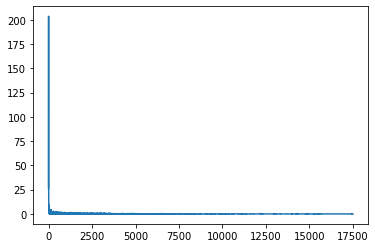

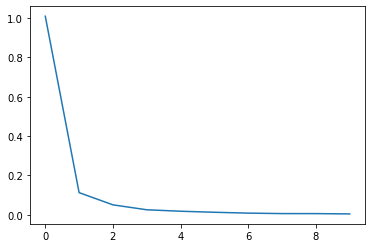

In [17]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'NORM',
    'DROP_PROB': 0.2,
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV2(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.5718851089477539
epoch: 1 loss: 0.9616235058403578
epoch: 2 step: 1000/1750 loss: 0.5691922307014465
epoch: 2 loss: 0.46891788275369617
epoch: 3 step: 1000/1750 loss: 0.5797828435897827
epoch: 3 loss: 0.6027561921693517
epoch: 4 step: 1000/1750 loss: 2.303830623626709
epoch: 4 loss: 2631.6875376388007
epoch: 5 step: 1000/1750 loss: 6.6595330238342285
epoch: 5 loss: 3564.3650047250476
epoch: 6 step: 1000/1750 loss: 2.3030471801757812
epoch: 6 loss: 6.96329794379643
epoch: 7 step: 1000/1750 loss: 2.302854299545288
epoch: 7 loss: 5.021369364465986
epoch: 8 step: 1000/1750 loss: 2.3027234077453613
epoch: 8 loss: 8.007569660050528
epoch: 9 step: 1000/1750 loss: 2.302631139755249
epoch: 9 loss: 3.8535209272929603
epoch: 10 step: 1000/1750 loss: 2.3025712966918945
epoch: 10 loss: 4.619808100019182


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train
Accuracy = 0.11252589470676477
F1 Score = 0.020230851968984283
Precision = 0.17792166809564636
Recall = 0.10003918176229372
Geometric Mean = 0.0


Test
Accuracy = 0.11246786632390746
F1 Score = 0.02022212235988958
Precision = 0.31125714285714284
Recall = 0.10007326007326008
Geometric Mean = 0.0



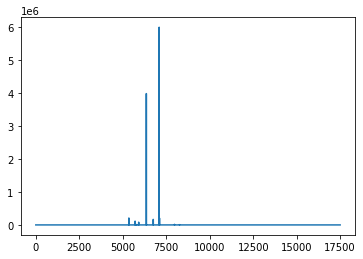

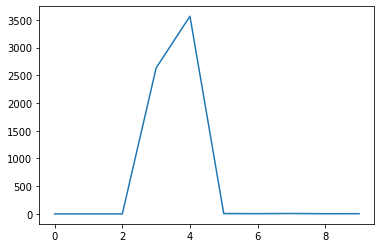

In [18]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'NORM',
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV2(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.17875219881534576
epoch: 1 loss: 1.0408357583198034
epoch: 2 step: 1000/1750 loss: 0.13760264217853546
epoch: 2 loss: 0.10929926648641412
epoch: 3 step: 1000/1750 loss: 0.13694100081920624
epoch: 3 loss: 0.04830418701889201
epoch: 4 step: 1000/1750 loss: 0.004366183187812567
epoch: 4 loss: 0.0319215915948185
epoch: 5 step: 1000/1750 loss: 0.006917936727404594
epoch: 5 loss: 0.017964033492429216
epoch: 6 step: 1000/1750 loss: 0.00887281447649002
epoch: 6 loss: 0.011255625382894388
epoch: 7 step: 1000/1750 loss: 0.010145601816475391
epoch: 7 loss: 0.009234168312848137
epoch: 8 step: 1000/1750 loss: 0.0015863145235925913
epoch: 8 loss: 0.007858240325012244
epoch: 9 step: 1000/1750 loss: 0.0012151137925684452
epoch: 9 loss: 0.005795208239925744
epoch: 10 step: 1000/1750 loss: 0.0004925458342768252
epoch: 10 loss: 0.008023003576059994
Train
Accuracy = 0.9974998214158154
F1 Score = 0.9976416637914504
Precisi

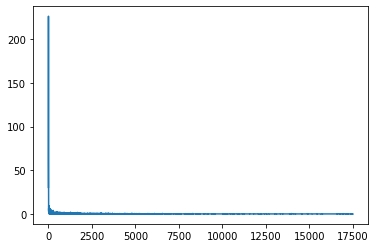

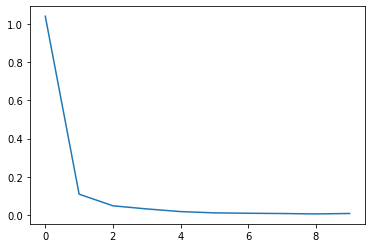

In [19]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'ABS_NORM',
    'DROP_PROB': 0.2,
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV2(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.27550429105758667
epoch: 1 loss: 0.9878412669034432
epoch: 2 step: 1000/1750 loss: 0.6295193433761597
epoch: 2 loss: 0.5343787765923979
epoch: 3 step: 1000/1750 loss: 0.04518701508641243
epoch: 3 loss: 0.3075797879516779
epoch: 4 step: 1000/1750 loss: 1.0114892721176147
epoch: 4 loss: 0.32634948969575844
epoch: 5 step: 1000/1750 loss: 0.00747164711356163
epoch: 5 loss: 0.27163126846021207
epoch: 6 step: 1000/1750 loss: 0.1232585608959198
epoch: 6 loss: 0.5898744102283381
epoch: 7 step: 1000/1750 loss: 2.7496249675750732
epoch: 7 loss: 1.873542337502752
epoch: 8 step: 1000/1750 loss: 2.2333977222442627
epoch: 8 loss: 9.383105562278203
epoch: 9 step: 1000/1750 loss: 2.296586036682129
epoch: 9 loss: 2.46612094770159
epoch: 10 step: 1000/1750 loss: 2.297323703765869
epoch: 10 loss: 2.595845167704991


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train
Accuracy = 0.09754268162011573
F1 Score = 0.01787736826442701
Precision = 0.10975087061344764
Recall = 0.10003694287838108
Geometric Mean = 0.0


Test
Accuracy = 0.09768637532133675
F1 Score = 0.017764185320145755
Precision = 0.009747215081405313
Recall = 0.1
Geometric Mean = 0.0



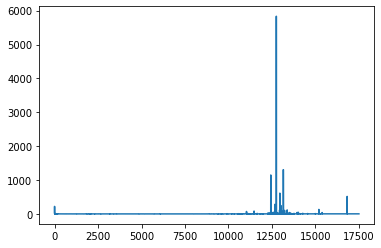

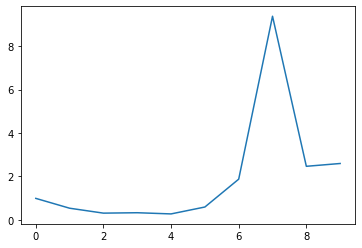

In [20]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'ABS_NORM',
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV2(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.19261780381202698
epoch: 1 loss: 1.0113880282313288
epoch: 2 step: 1000/1750 loss: 0.08258350938558578
epoch: 2 loss: 0.08105683845625962
epoch: 3 step: 1000/1750 loss: 0.012467703782022
epoch: 3 loss: 0.023689771253963824
epoch: 4 step: 1000/1750 loss: 0.013186579570174217
epoch: 4 loss: 0.007600815278882562
epoch: 5 step: 1000/1750 loss: 0.0063889664597809315
epoch: 5 loss: 0.002705013506420073
epoch: 6 step: 1000/1750 loss: 0.0018767229048535228
epoch: 6 loss: 0.0013265342492994542
epoch: 7 step: 1000/1750 loss: 0.00099697127006948
epoch: 7 loss: 0.0008654002156279148
epoch: 8 step: 1000/1750 loss: 0.0006560446927323937
epoch: 8 loss: 0.0007568832023443
epoch: 9 step: 1000/1750 loss: 0.0005475401412695646
epoch: 9 loss: 0.0006447338958613987
epoch: 10 step: 1000/1750 loss: 0.0004569941957015544
epoch: 10 loss: 0.0005806320780206826
Train
Accuracy = 0.9999821415815415
F1 Score = 0.9999823749457899
Pr

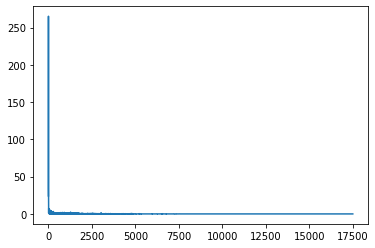

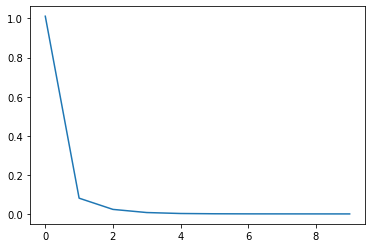

In [21]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'TANH',
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV2(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.2206256091594696
epoch: 1 loss: 0.9868855216024931
epoch: 2 step: 1000/1750 loss: 0.017056219279766083
epoch: 2 loss: 0.07584653156180866
epoch: 3 step: 1000/1750 loss: 0.001566875260323286
epoch: 3 loss: 0.02121777043311054
epoch: 4 step: 1000/1750 loss: 0.0017765254015102983
epoch: 4 loss: 0.006706820813275369
epoch: 5 step: 1000/1750 loss: 0.0009990779217332602
epoch: 5 loss: 0.002315118805360271
epoch: 6 step: 1000/1750 loss: 0.0008456911891698837
epoch: 6 loss: 0.0011800973836549977
epoch: 7 step: 1000/1750 loss: 0.0007699248963035643
epoch: 7 loss: 0.0008748489718005723
epoch: 8 step: 1000/1750 loss: 0.0007383797783404589
epoch: 8 loss: 0.0007321296154299911
epoch: 9 step: 1000/1750 loss: 0.0005527885514311492
epoch: 9 loss: 0.0006447135296888534
epoch: 10 step: 1000/1750 loss: 0.0007195618818514049
epoch: 10 loss: 0.000562211291470289
Train
Accuracy = 1.0
F1 Score = 1.0
Precision = 1.0
Recall = 

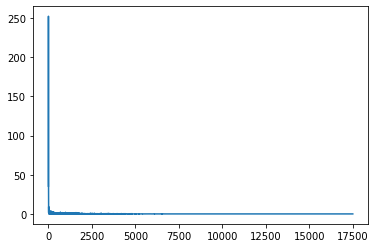

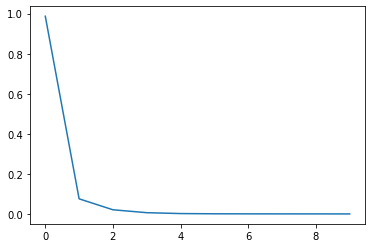

In [22]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'TANH',
    'DROP_PROB': 0.2,
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV2(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

# V3

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.7016294002532959
epoch: 1 loss: 1.0218544332619057
epoch: 2 step: 1000/1750 loss: 0.29923564195632935
epoch: 2 loss: 0.11079174949019736
epoch: 3 step: 1000/1750 loss: 0.03483475372195244
epoch: 3 loss: 0.05341003689313116
epoch: 4 step: 1000/1750 loss: 0.008622521534562111
epoch: 4 loss: 0.0300887540530192
epoch: 5 step: 1000/1750 loss: 0.0043130856938660145
epoch: 5 loss: 0.023227700113349785
epoch: 6 step: 1000/1750 loss: 0.023361001163721085
epoch: 6 loss: 0.014503974413030214
epoch: 7 step: 1000/1750 loss: 0.018564384430646896
epoch: 7 loss: 0.01009365814281458
epoch: 8 step: 1000/1750 loss: 0.004436261486262083
epoch: 8 loss: 0.008434306914303696
epoch: 9 step: 1000/1750 loss: 0.0027680613566190004
epoch: 9 loss: 0.00641749244385977
epoch: 10 step: 1000/1750 loss: 0.159976527094841
epoch: 10 loss: 0.00545668831269884
Train
Accuracy = 0.9983748839202801
F1 Score = 0.9985305730628484
Precision = 0.

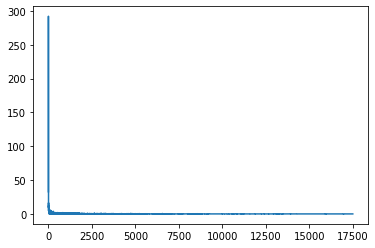

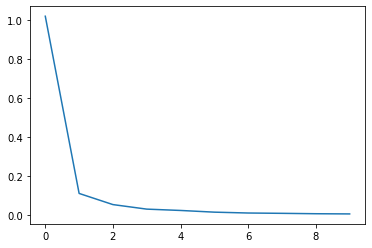

In [43]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'NORM',
    'DROP_PROB': 0.2,
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV3(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.05349462106823921
epoch: 1 loss: 1.144485065482981
epoch: 2 step: 1000/1750 loss: 0.3111937642097473
epoch: 2 loss: 1.3390824191753885
epoch: 3 step: 1000/1750 loss: 2.303762435913086
epoch: 3 loss: 8323.822286478315
epoch: 4 step: 1000/1750 loss: 2.30330491065979
epoch: 4 loss: 5.199833769798278
epoch: 5 step: 1000/1750 loss: 2.3030219078063965
epoch: 5 loss: 8.04528254209246
epoch: 6 step: 1000/1750 loss: 2.3028228282928467
epoch: 6 loss: 4.064206084387643
epoch: 7 step: 1000/1750 loss: 2.3026859760284424
epoch: 7 loss: 7.69857897581373
epoch: 8 step: 1000/1750 loss: 2.3025946617126465
epoch: 8 loss: 86.41037832096644
epoch: 9 step: 1000/1750 loss: 2.302544355392456
epoch: 9 loss: 9.749045193127223
epoch: 10 step: 1000/1750 loss: 2.3025057315826416
epoch: 10 loss: 5.743791197504316


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train
Accuracy = 0.11256161154368169
F1 Score = 0.020443886447934382
Precision = 0.11125221025558592
Recall = 0.10008919747613709
Geometric Mean = 0.0


Test
Accuracy = 0.112539274493002
F1 Score = 0.020379574962455304
Precision = 0.011254731129043776
Recall = 0.09993654822335026
Geometric Mean = 0.0



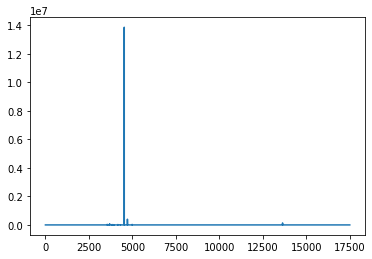

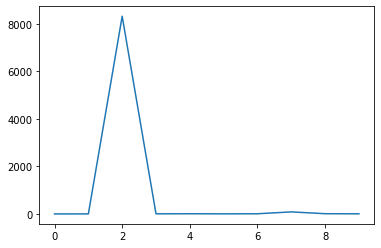

In [44]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'NORM',
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV3(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.06304420530796051
epoch: 1 loss: 1.0598770314888222
epoch: 2 step: 1000/1750 loss: 0.08151954412460327
epoch: 2 loss: 0.11732136907606452
epoch: 3 step: 1000/1750 loss: 0.032574668526649475
epoch: 3 loss: 0.06281062100186319
epoch: 4 step: 1000/1750 loss: 0.3553709089756012
epoch: 4 loss: 0.03880219416357327
epoch: 5 step: 1000/1750 loss: 0.009898316115140915
epoch: 5 loss: 0.024006452280395805
epoch: 6 step: 1000/1750 loss: 0.01681656949222088
epoch: 6 loss: 0.01830512463447225
epoch: 7 step: 1000/1750 loss: 0.006027099210768938
epoch: 7 loss: 0.013988324498652739
epoch: 8 step: 1000/1750 loss: 0.02232290990650654
epoch: 8 loss: 0.009793682360157619
epoch: 9 step: 1000/1750 loss: 0.020736509934067726
epoch: 9 loss: 0.008922041011025223
epoch: 10 step: 1000/1750 loss: 0.0019574910402297974
epoch: 10 loss: 0.007969673889256878
Train
Accuracy = 0.9982498749910708
F1 Score = 0.9980524455734372
Precision =

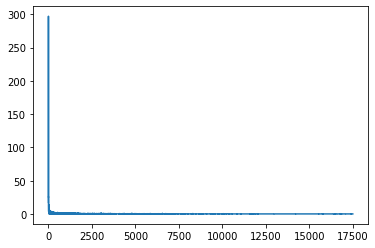

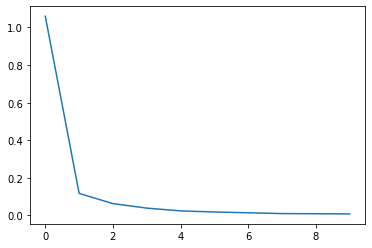

In [45]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'ABS_NORM',
    'DROP_PROB': 0.2,
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV3(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.692058801651001
epoch: 1 loss: 0.9919338019365054
epoch: 2 step: 1000/1750 loss: 0.36491575837135315
epoch: 2 loss: 1.082128643825251
epoch: 3 step: 1000/1750 loss: 0.17559851706027985
epoch: 3 loss: 0.6124341400553073
epoch: 4 step: 1000/1750 loss: 0.6350250840187073
epoch: 4 loss: 0.7705047082709414
epoch: 5 step: 1000/1750 loss: 0.3939204812049866
epoch: 5 loss: 0.5666447665425284
epoch: 6 step: 1000/1750 loss: 0.47264811396598816
epoch: 6 loss: 0.481816457248692
epoch: 7 step: 1000/1750 loss: 1.1025646924972534
epoch: 7 loss: 0.433923199539605
epoch: 8 step: 1000/1750 loss: 0.49112656712532043
epoch: 8 loss: 0.39180033279343374
epoch: 9 step: 1000/1750 loss: 0.5327553153038025
epoch: 9 loss: 0.365361393618597
epoch: 10 step: 1000/1750 loss: 0.48418471217155457
epoch: 10 loss: 0.3403498069295227
Train
Accuracy = 0.9224766054718194
F1 Score = 0.9216934534252594
Precision = 0.9230837280867107
Recall =

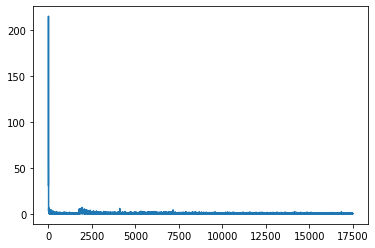

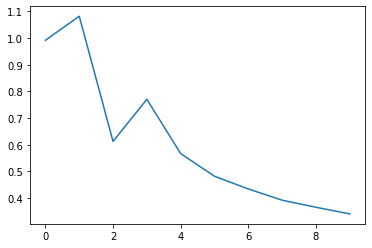

In [46]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'ABS_NORM',
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV3(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.22388707101345062
epoch: 1 loss: 1.092511439544656
epoch: 2 step: 1000/1750 loss: 0.015101340599358082
epoch: 2 loss: 0.07826519952043912
epoch: 3 step: 1000/1750 loss: 0.01654331386089325
epoch: 3 loss: 0.02268666438244275
epoch: 4 step: 1000/1750 loss: 0.007008608430624008
epoch: 4 loss: 0.007490560843946046
epoch: 5 step: 1000/1750 loss: 0.006170809268951416
epoch: 5 loss: 0.0030338365692348036
epoch: 6 step: 1000/1750 loss: 0.003517580684274435
epoch: 6 loss: 0.0016195429082143684
epoch: 7 step: 1000/1750 loss: 0.0024154148995876312
epoch: 7 loss: 0.0011394269865834627
epoch: 8 step: 1000/1750 loss: 0.0017901655519381166
epoch: 8 loss: 0.0009221217599078305
epoch: 9 step: 1000/1750 loss: 0.0014714414719492197
epoch: 9 loss: 0.0007850107090362144
epoch: 10 step: 1000/1750 loss: 0.0012965522473677993
epoch: 10 loss: 0.000687861597297472
Train
Accuracy = 1.0
F1 Score = 1.0
Precision = 1.0
Recall = 1.0

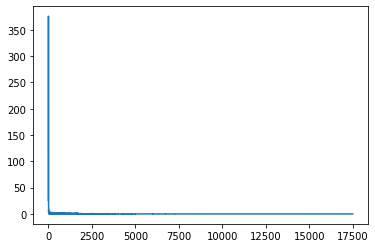

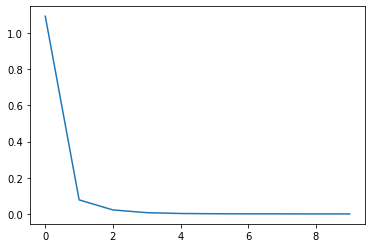

In [47]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'TANH',
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV3(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)

Train: 55996
Test: 14004
Max sample per class: 7877
epoch: 1 step: 1000/1750 loss: 0.3690691292285919
epoch: 1 loss: 0.991333815018108
epoch: 2 step: 1000/1750 loss: 0.19311071932315826
epoch: 2 loss: 0.07429775187818347
epoch: 3 step: 1000/1750 loss: 0.003595785005018115
epoch: 3 loss: 0.019702781645218367
epoch: 4 step: 1000/1750 loss: 0.005569763015955687
epoch: 4 loss: 0.006045683735211632
epoch: 5 step: 1000/1750 loss: 0.011138911359012127
epoch: 5 loss: 0.0023894679318304302
epoch: 6 step: 1000/1750 loss: 0.0018849101616069674
epoch: 6 loss: 0.0013114934888679792
epoch: 7 step: 1000/1750 loss: 0.0014797915937379003
epoch: 7 loss: 0.0009582854057409479
epoch: 8 step: 1000/1750 loss: 0.001203066436573863
epoch: 8 loss: 0.0007770999953213179
epoch: 9 step: 1000/1750 loss: 0.0009920188458636403
epoch: 9 loss: 0.0006628941818699202
epoch: 10 step: 1000/1750 loss: 0.0008228850783780217
epoch: 10 loss: 0.0005783218828185974
Train
Accuracy = 1.0
F1 Score = 1.0
Precision = 1.0
Recall = 1.

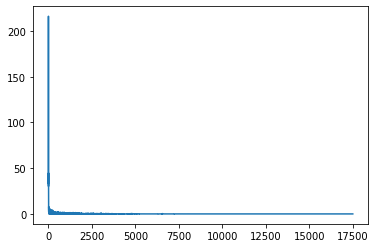

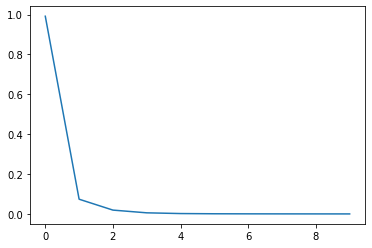

In [48]:
cfg = {
    'OUTPUT_TYPE': 'NUMBERS', 
    'PROB_METHOD': 'TANH',
    'DROP_PROB': 0.2,
    'LOSS': 'NLLLoss',
    'OPTIMIZER': 'SGD',
    'PRINT_EVERY': 1000,
    'LR': 0.001,
    'EPOCH': 10,
    'LOAD_METHOD': 'ORIGINAL',
    'BATCH_SIZE': 32,
    'EVALUATION_METHODS': ['ACCURACY', 'F1_SCORE', 'PRECISION', 'RECALL', 'GMEAN'],
}
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)
dataprocessor = MNISTLoader(cfg, None)
x_train, y_train, x_test, y_test = dataprocessor.load_dataset()
model = LinearModelGradBasedDropV3(cfg, "", 28*28, dataprocessor)
model.fit(x_train, y_train)
evaluate(cfg, model, x_train, x_test, y_train, y_test)